In [1]:
!pip install tensorflow numpy matplotlib

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


In [14]:
def load_images(directory, size=(256, 256)):
    color_images = []
    bw_images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # or .png, etc.
            # Load the image
            img = Image.open(os.path.join(directory, filename)).resize(size)

            # Convert to numpy array and normalize
            img_np = np.array(img).astype('float32') / 255.

            # Split the image in half
            middle = img_np.shape[1] // 2
            color_part, bw_part = img_np[:, :middle, :], img_np[:, middle:, :]
            # Convert the image to grayscale
            bw_part = np.dot(bw_part[...,:3], [0.2989, 0.5870, 0.1140])


            # Add to lists
            color_images.append(color_part)
            bw_images.append(bw_part)

    return np.array(bw_images), np.array(color_images)

In [15]:
train_bw, train_color = load_images('./Data/train/')
test_bw, test_color = load_images('./Data/test/')
#print the number of images in the training and test sets
print('Number of images in the training set: {}'.format(train_bw.shape[0]))
print('Number of images in the test set: {}'.format(test_bw.shape[0]))

Number of images in the training set: 11000
Number of images in the test set: 859


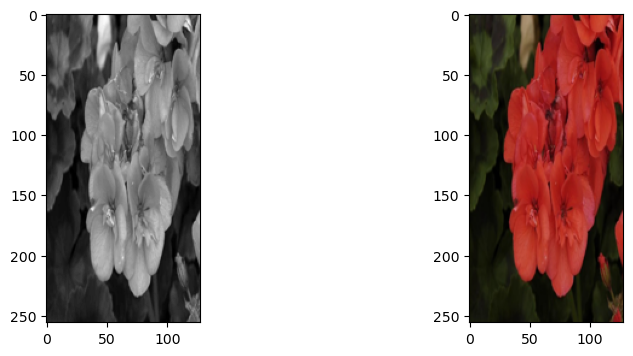

In [28]:
# Display a random training image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(train_bw[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(train_color[0])

In [19]:
train_bw = np.expand_dims(train_bw, axis=3)
test_bw = np.expand_dims(test_bw, axis=3)

In [21]:
# get the size of the images
size = train_bw.shape[1:]
print("Training set shape:", train_bw.shape)
print("Test set shape:", test_bw.shape)

Training set shape: (11000, 256, 128, 1)
Test set shape: (859, 256, 128, 1)


In [47]:
import optuna
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def objective(trial):
    # Hyperparameters to be tuned by Optuna
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    l2_strength = trial.suggest_float('l2_strength', 1e-10, 1e-2)

    # Model architecture
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 128, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rate))

    # Output layer for color (RGB)
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))


    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    history = model.fit(train_bw, train_color, validation_data=(test_bw, test_color), epochs=10, verbose=0)  # Adjust epochs and verbosity as needed

    # Get the best validation loss from the epochs
    best_val_loss = np.min(history.history['val_loss'])

    return best_val_loss

In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Adjust the number of trials as needed

# Fetch the best parameters
best_params = study.best_params
print('Best parameters:', best_params)

[I 2023-12-01 11:30:50,703] A new study created in memory with name: no-name-82b55d51-aad5-4dcf-ae19-d17181d214ad
[W 2023-12-01 11:31:22,993] Trial 0 failed with parameters: {'dropout_rate': 0.23906484344332812, 'learning_rate': 0.04987895518863587, 'l2_strength': 0.003578755189102242} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/lucfer/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/ns/hlcwc6_10pq7bmk8473dlt440000gn/T/ipykernel_81608/3048491411.py", line 28, in objective
    history = model.fit(train_bw, train_color, validation_data=(test_bw, test_color), epochs=10, verbose=0)  # Adjust epochs and verbosity as needed
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lucfer/anaconda3/lib/python3.11/site-packages/keras/src/utils

KeyboardInterrupt: 

In [43]:
# Build the model with the optimal hyperparameters
model = Sequential()
model.add(InputLayer(input_shape=(256, 128, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(best_params['l2_strength'])))
model.add(Dropout(best_params['dropout_rate']))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(best_params['l2_strength'])))
model.add(Dropout(best_params['dropout_rate']))

# Output layer for color (RGB)
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')
model.summary()

NameError: name 'best_params' is not defined

In [ ]:
# Train the model
history = model.fit(train_bw, train_color, validation_data=(test_bw, test_color), epochs=10, verbose=1)

In [ ]:
model.save('colorize_autoencoder.model')

In [ ]:
output = model.predict(test_bw)

# Display some test images and their colorized outputs
for i in range(5):
    plt.figure(figsize=(10, 4))

    # Original B&W Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_bw[i].reshape(size[0], size[1]), cmap='gray')

    # Colorized Image
    plt.subplot(1, 2, 2)
    plt.imshow(output[i].reshape(size[0], size[1], 3))

    plt.show()